In [2]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [3]:
# 超参数设置
config = {
    "model_name": "resnet",  # 可选 "resnet" 或 "vgg"
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"


In [4]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("不支持的模型名称，请选择 'resnet' 或 'vgg'")
    return model, input_size


In [5]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


In [6]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label


In [7]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes


In [8]:
def train_model(model, device, train_loader, test_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_acc = 0.0
    no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Accuracy {train_acc:.4f}")

        if train_acc > best_acc:
            best_acc = train_acc
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered.")
                break
    return model, history


In [9]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 1/15 [00:20<04:47, 20.50s/it]

Epoch 1: Train Loss 1.1167, Accuracy 0.6483


 13%|█▎        | 2/15 [00:40<04:25, 20.39s/it]

Epoch 2: Train Loss 0.7903, Accuracy 0.7521


 20%|██        | 3/15 [01:01<04:04, 20.35s/it]

Epoch 3: Train Loss 0.6504, Accuracy 0.7927


 27%|██▋       | 4/15 [01:22<03:48, 20.79s/it]

Epoch 4: Train Loss 0.5821, Accuracy 0.8171


 33%|███▎      | 5/15 [01:44<03:30, 21.06s/it]

Epoch 5: Train Loss 0.5238, Accuracy 0.8360


 40%|████      | 6/15 [02:05<03:11, 21.23s/it]

Epoch 6: Train Loss 0.5072, Accuracy 0.8404


 47%|████▋     | 7/15 [02:26<02:49, 21.17s/it]

Epoch 7: Train Loss 0.4914, Accuracy 0.8499


 53%|█████▎    | 8/15 [02:47<02:28, 21.16s/it]

Epoch 8: Train Loss 0.4436, Accuracy 0.8593


 60%|██████    | 9/15 [03:08<02:05, 20.99s/it]

Epoch 9: Train Loss 0.4367, Accuracy 0.8622


 67%|██████▋   | 10/15 [03:29<01:44, 20.98s/it]

Epoch 10: Train Loss 0.4335, Accuracy 0.8644


 73%|███████▎  | 11/15 [03:50<01:23, 20.92s/it]

Epoch 11: Train Loss 0.3975, Accuracy 0.8695


 80%|████████  | 12/15 [04:11<01:02, 20.98s/it]

Epoch 12: Train Loss 0.3898, Accuracy 0.8755


 87%|████████▋ | 13/15 [04:32<00:41, 20.93s/it]

Epoch 13: Train Loss 0.3952, Accuracy 0.8795


 93%|█████████▎| 14/15 [04:53<00:20, 20.94s/it]

Epoch 14: Train Loss 0.3497, Accuracy 0.8878


100%|██████████| 15/15 [05:14<00:00, 20.94s/it]

Epoch 15: Train Loss 0.3600, Accuracy 0.8867


Evaluation Metrics (Precision, Recall, F1-score):

              precision    recall  f1-score   support

 Agriculture     0.9205    0.8688    0.8939       160
     Airport     0.8805    0.8750    0.8777       160
       Beach     0.9574    0.8438    0.8970       160
        City     0.8603    0.9625    0.9086       160
      Desert     0.9102    0.9500    0.9297       160
      Forest     0.9682    0.9500    0.9590       160
   Grassland     0.9580    0.8562    0.9043       160
     Highway     0.8500    0.9563    0.9000       160
        Lake     0.6996    0.9750    0.8146       160
    Mountain     0.8779    0.9437    0.9096       160
     Parking     0.9926    0.8375    0.9085       160
        Port     0.8556    0.9625    0.9059       160
     Railway     0.9624    0.8000    0.8737       160
 Residential     0.9630    0.9750    0.9689       160
       River     0.9492    0.7000    0.8058       160

    accuracy                         0.8971      2400
   macro avg     0.9070    0.

<Figure size 1200x1000 with 0 Axes>

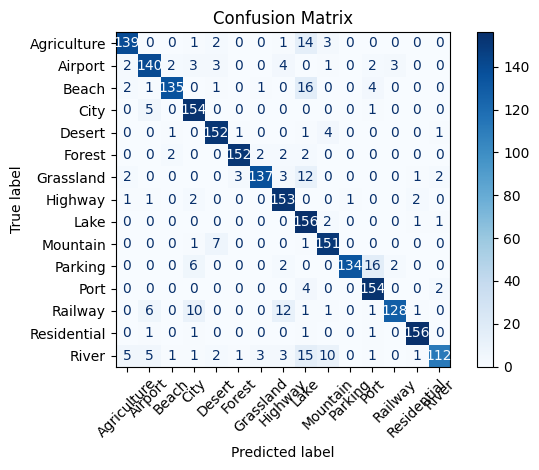

In [10]:
# 加载数据
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"],
    sample_ratio=config["sample_ratio"]
)

# 初始化模型
model, input_size = initialize_model(
    model_name=config["model_name"],
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

# 数据增强
train_transform, test_transform = get_transforms(input_size)

# 构建Dataset和Loader
train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# 损失函数与优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# 训练模型
model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"],
    patience=5
)

# 评估
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

# 输出三种指标：precision、recall、f1-score
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Evaluation Metrics (Precision, Recall, F1-score):\n")
print(report)

# 混淆矩阵可视化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(12, 10))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()
